# Exploring the data
First i will load the train data set and binarize all the columns that are not quantative. First I am going to open the JSONL file and I am going to preprocess the data. After that I am going to convert the data to a pandas frame. We see during our explaration of the data that the dataset contains a lot of entries which are considered duplicate (a duplicate entry is an entry where all columns are the same other than the premise and the hypothesis) . For our data analysis we will use only the data which does not have NA for the premise and hypothesis .
For our validation set we will use 10 percent of the training set. We have modified the entailment column so as to have numerical data (0 = Entailment , 1 = Contradiction  , 2 = NotMentioned).

In [ ]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install matplotlib
%pip install seaborn
%pip install torch
%pip install pipeline
%pip install transformers datasets torch


In [4]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:

import  nltk




nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
vectorizer = TfidfVectorizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


def show_class_distribution(df , title:str):
    sns.displot(data=df, x='label')
    plt.title(title)
    plt.ylabel("Number of Examples")
    plt.show()
def show_distribution(df):

    df["premise_length"] = df["premise"].apply(len)
    df = df[df["premise_length"]!=0]
    df["hypothesis_length"] = df["hypothesis"].apply(len)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df["premise_length"], kde=True)
    plt.title("Premise Length Distribution")
    plt.xlabel("Length")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.histplot(df["hypothesis_length"], kde=True)
    plt.title("Hypothesis Length Distribution")
    plt.xlabel("Length")
    avg_chars = df['premise'].dropna().apply(len).mean()
    max_chars = df['premise'].dropna().apply(len).max()
    min_chars = df['premise'].dropna().apply(len).min()
    mean_chars = df['premise'].dropna().apply(len).mean()

    print(f"average len {avg_chars}")
    print(f"max len {max_chars}")
    print(f"min len {min_chars}")
    print(f"mean len {mean_chars}")



In [7]:


DANGEROUS = {
    "not","no","nor","never","shall","must","may","should","will",
    "unless","except","until","where","when","and","or","without"
}



def preprocess_text(text):


    words = word_tokenize(text.lower())


    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]


    stop_words = set(stopwords.words('english')) - DANGEROUS
    words = [word for word in words if word not in stop_words]


    processed_words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words]


    unique_words = list(dict.fromkeys(processed_words))


    preprocessed_text = ' '.join(unique_words)
    return preprocessed_text





# Data cleaning and preprocessing
We are going to clean up the data and turn the categorical variable entailment  into numerical  by mapping each of the values three values to a value of {0,1,2}.
The preprocessing of the text consists of tokenizing the words and removing the stop words that are not negations which do not add much meaning to the sentence and convert the words to lower case. We also play around with lemmatizing the words and stemming but we are careful as to not add the same word twice that would have a impact during the vectorizing of the data.


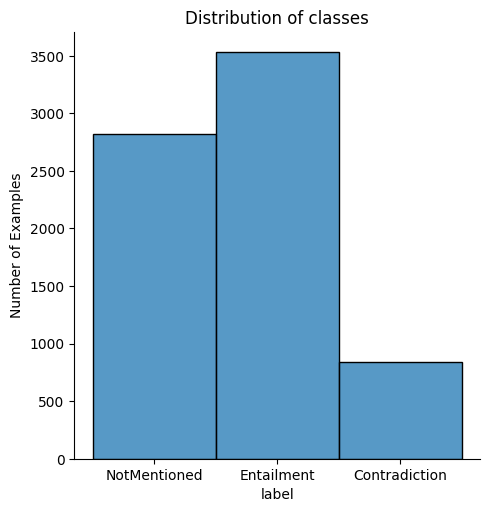

Index(['doc_id', 'key', 'premise', 'hypothesis', 'label'], dtype='object')
2882


/tmp/ipython-input-2166520830.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hypothesis_length"] = df["hypothesis"].apply(len)


average len 487.4255319148936
max len 3098
min len 36
mean len 487.4255319148936
Train set size: 6471
Test set size: 2091
Validation set size: 720


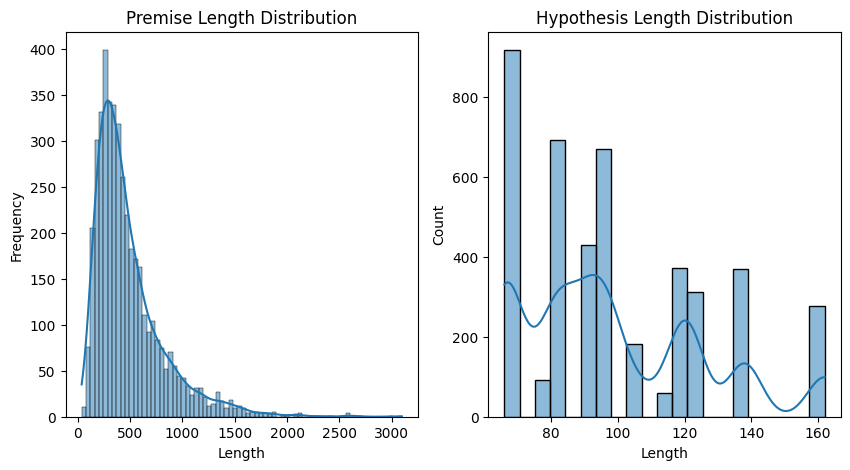

In [8]:
import numpy as np
import pandas as pd
import os
import json
from sklearn.model_selection import train_test_split

data = []
with open('train.jsonl', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df = df.dropna()
show_class_distribution(df, "Distribution of classes")
# Binarizing non-quantitative columns
print(df.columns)

df['preprocessed_premise'] = df['premise'].apply(preprocess_text)
df['preprocessed_hypothesis'] = df['hypothesis'].apply(preprocess_text)

#view number of duplicates
print(df.duplicated(subset=['premise','hypothesis']).sum())


test_data = []
with open('test.jsonl', encoding='utf-8') as f:
    for line in f:
        test_data.append(json.loads(line))
X_test = pd.DataFrame(test_data)
X_test['label_id'] = X_test["label"].apply(
    lambda x: 1 if x == "Contradiction" else (2 if x == "NotMentioned" else 0)
)
df['label_id'] = df["label"].apply(
    lambda x: 1 if x == "Contradiction" else (2 if x == "NotMentioned" else 0)
)
X_train , X_validation = train_test_split(df, test_size=0.10, random_state=42)

show_distribution(df)
#show_distribution(X_train , "training set")
#show_distribution(X_validation , "validation set")


X_test['preprocessed_premise'] = X_test['premise'].apply(preprocess_text)
X_test['preprocessed_hypothesis'] = X_test['hypothesis'].apply(preprocess_text)
print(f'Train set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Validation set size: {X_validation.shape[0]}')


y_train = X_train['label_id']
y_test = X_test["label"].apply(lambda x: 1 if x == "Contradiction" else (2 if x == "NotMentioned" else 0))
y_pred = X_validation['label_id']
# print(X_train["label_id"].values())
X_train = X_train.drop(columns=['label_id'])
X_pred = X_test.drop(columns=['label_id'])






## Vectorzing the data
Here we work on processing the data and transform it using TF-IDF after first separating the premise and the hypotesis by a separator token. We convert the training and the test dataset using TF-IDF.

In [9]:
print(X_train.columns)

X_train_text = X_train['preprocessed_premise'] + "[SEP]" + X_train['preprocessed_hypothesis']
X_test_text = X_test['preprocessed_premise'] + "[SEP]" + X_test['preprocessed_hypothesis']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2,3))

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)
print(f"{X_train_vec}")

Index(['doc_id', 'key', 'premise', 'hypothesis', 'label',
       'preprocessed_premise', 'preprocessed_hypothesis'],
      dtype='object')
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 195012 stored elements and shape (6471, 5000)>
  Coords	Values
  (0, 4187)	0.11159373658429472
  (0, 3713)	0.10375856040734384
  (0, 3158)	0.16726479810195966
  (0, 2417)	0.3163739564974083
  (0, 43)	0.3172318617695649
  (0, 2093)	0.26078454305852417
  (0, 4329)	0.2610032562183819
  (0, 807)	0.31701655270942836
  (0, 4188)	0.11159373658429472
  (0, 3725)	0.16829765686562836
  (0, 3159)	0.3172318617695649
  (0, 2418)	0.3172318617695649
  (0, 44)	0.3172318617695649
  (0, 2094)	0.2610032562183819
  (0, 4330)	0.3172318617695649
  (1, 4187)	0.04730930293889464
  (1, 3713)	0.04398764049904094
  (1, 3158)	0.07091061959773404
  (1, 4188)	0.04730930293889464
  (1, 3725)	0.07134849209523379
  (1, 647)	0.25110719681941307
  (1, 4839)	0.1492617674087092
  (1, 2651)	0.2169094776342451
  (1, 2338)	0.24

We start out by finding the majority classifier which in this case is the entailment class. This will be relevant because it will help us better estimate the quality of our model due to the fact that only a small percentage of the entries are contradictions. We try out some simple ML models and find their accuracy on the test set. After training the model we use 5-fold cross validation to validate our findings. We are getting the best results for the logistic regression model

In [10]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
#Majority classifier
majority_class = y_test.value_counts().idxmax()
majority_acc = (y_test == majority_class).mean()
print("Majority classifier accuracy:", majority_acc)

logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

logistic_grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logistic_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

logistic_grid.fit(X_train_vec, y_train)
logistic_best = logistic_grid.best_estimator_

logistic_predictions = logistic_best.predict(X_test_vec)
print("Logistic Regression:")
print(classification_report(y_test, logistic_predictions))




rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

rf_grid.fit(X_train_vec, y_train)
rf_best = rf_grid.best_estimator_

rf_predictions = rf_best.predict(X_test_vec)
print("Random Forest:")
print("Best parametars:", rf_grid.best_params_)
print(classification_report(y_test,rf_predictions))


svc_params = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear']
}

svc_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=svc_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

svc_grid.fit(X_train_vec, y_train)
svc_best = svc_grid.best_estimator_

svc_predictions = svc_best.predict(X_test_vec)
print("SVC")
print("Best parametars:", svc_grid.best_params_)
print(classification_report(y_test, svc_predictions))

Majority classifier accuracy: 0.46293639406982307
Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       968
           1       0.86      0.76      0.81       220
           2       0.98      1.00      0.99       903

    accuracy                           0.95      2091
   macro avg       0.93      0.91      0.92      2091
weighted avg       0.95      0.95      0.95      2091

Random Forest:
Best parametars: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       968
           1       0.82      0.76      0.79       220
           2       1.00      1.00      1.00       903

    accuracy                           0.96      2091
   macro avg       0.92      0.91      0.92      2091
weighted avg       0.96      0.96      0.96      2091

SVC
Best parametars: {'C': 1, 'kernel': 'linear'}
              precisi

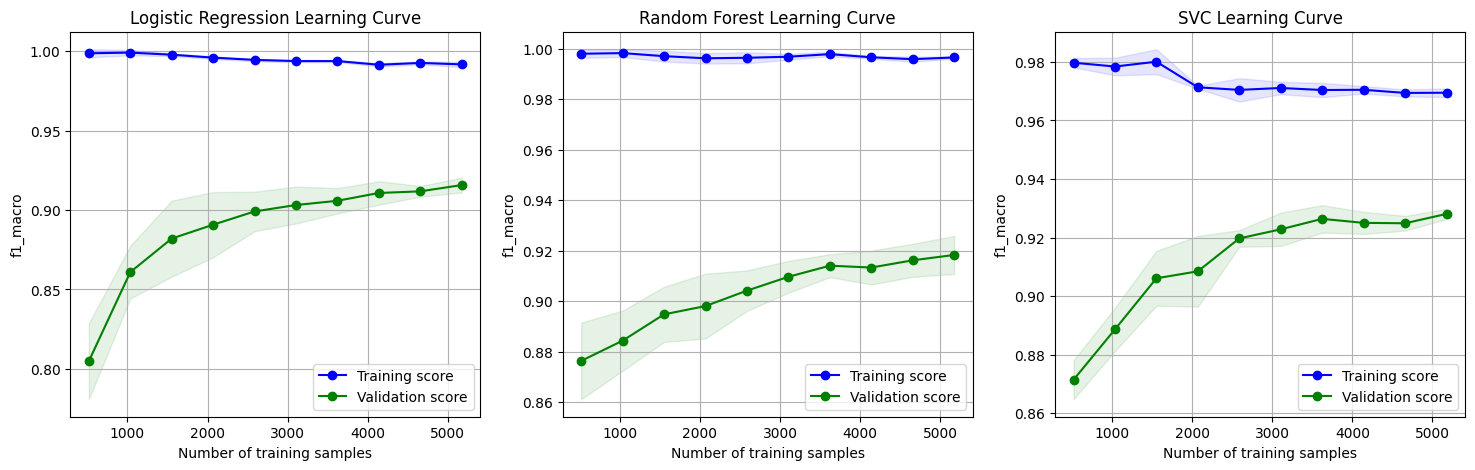

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, title, cv=5, scoring='f1_macro'):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='green')
    plt.title(title)
    plt.xlabel('Number of training samples')
    plt.ylabel(scoring)
    plt.legend()
    plt.grid(True)
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plot_learning_curve(logistic_best, X_train_vec, y_train, "Logistic Regression Learning Curve")

plt.subplot(1,3,2)
plot_learning_curve(rf_best, X_train_vec, y_train, "Random Forest Learning Curve")

plt.subplot(1,3,3)
plot_learning_curve(svc_best, X_train_vec, y_train, "SVC Learning Curve")

plt.show()



## Task 3- Transformer-based Classifier

In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np




Once again for the thrid task we process the data and split the training dataset between a validation set and training set

In [13]:

df_train = pd.read_json("train.jsonl", lines=True)
df_test  = pd.read_json("test.jsonl", lines=True)


label_map = {"Entailment": 0, "Contradiction": 1, "NotMentioned": 2}
df_train["label"] = df_train["label"].map(label_map)
df_test["label"]  = df_test["label"].map(label_map)

print("Train class distribution BEFORE balancing:")
print(df_train["label"].value_counts())


from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train["label"])

print("\nTrain class distribution AFTER split:")
print(df_train["label"].value_counts())
print(f"\nValidation class distribution:")
print(df_val["label"].value_counts())
print(f"\nTotal training samples: {len(df_train)}")
print(f"Total validation samples: {len(df_val)}")

Train class distribution BEFORE balancing:
label
0    3530
2    2820
1     841
Name: count, dtype: int64

Train class distribution AFTER split:
label
0    2823
2    2256
1     673
Name: count, dtype: int64

Validation class distribution:
label
0    707
2    564
1    168
Name: count, dtype: int64

Total training samples: 5752
Total validation samples: 1439


### Choosing parametars
We decided on using law-english-roberta-base due to its pretraining on law texts. We are adding padding so we can handle the empty premises in our dataset. We decided on a length of 300 because during our analysis we found out a lot of the premises were empty and so as to give the model more context we bumped up the padding.


In [14]:

MODEL_NAME = "joelito/legal-english-roberta-base"
torch.cuda.empty_cache()
MAX_LEN = 300
BATCH_SIZE = 42
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class NLIDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=MAX_LEN):

        premises = [str(p) if p and str(p).strip() else "" for p in df["premise"]]
        hypotheses = [str(h) for h in df["hypothesis"]]

        self.enc = tokenizer(
            premises,
            hypotheses,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors=None
        )
        self.labels = list(df["label"])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = NLIDataset(df_train, tokenizer)
val_dataset = NLIDataset(df_val, tokenizer)
test_dataset  = NLIDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,  num_workers = 4,shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Model: {MODEL_NAME}, Max length: {MAX_LEN}, Batch size: {BATCH_SIZE}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Train dataset size: 5752
Validation dataset size: 1439
Test dataset size: 2091
Model: joelito/legal-english-roberta-base, Max length: 300, Batch size: 42


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


We are goind to be fine-tunning the model to solve this NLI problem (Look for 3 difirent classes Enatailment , Contradiction , NotMentioned) and add hidden dropout probability so as to avoid overfitting. The learning rate is set to 3e-5 and we are using AdamW as an optimizer. We also configure the model to decreaase the learning rate when it plateaus

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  #
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model.to(device)


learning_rate = 3e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Model initialized.")
print(f"Learning rate: {learning_rate}")
print(f"Using learning rate scheduler with patience=2")


Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at joelito/legal-english-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized.
Learning rate: 3e-05
Using learning rate scheduler with patience=2


In [ ]:
EPOCHS = 4
best_val_loss = float('inf')
patience_counter = 0
patience = 2
for epoch in range(EPOCHS):

    model.train()
    train_loss = 0
    train_batches = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_batches += 1
        loop.set_postfix(loss=loss.item(), avg_loss=train_loss/train_batches)

    avg_train_loss = train_loss / train_batches


    model.eval()
    val_loss = 0
    val_batches = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_batches += 1


            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_batches
    val_accuracy = val_correct / val_total


    scheduler.step(avg_val_loss)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}\n")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print(f"New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break

print("Training completed!")

Epoch 1/4 [Train]: 100%|██████████| 137/137 [04:52<00:00,  2.14s/it, avg_loss=0.232, loss=0.0312]



Epoch 1 Summary:
  Train Loss: 0.2316
  Val Loss: 0.1408
  Val Accuracy: 0.9361
  Learning Rate: 3.00e-05

  ✓ New best validation loss: 0.1408


Epoch 2/4 [Train]: 100%|██████████| 137/137 [04:51<00:00,  2.13s/it, avg_loss=0.0812, loss=0.014]



Epoch 2 Summary:
  Train Loss: 0.0812
  Val Loss: 0.0864
  Val Accuracy: 0.9736
  Learning Rate: 3.00e-05

  ✓ New best validation loss: 0.0864


Epoch 3/4 [Train]: 100%|██████████| 137/137 [04:51<00:00,  2.13s/it, avg_loss=0.0588, loss=0.0121]



Epoch 3 Summary:
  Train Loss: 0.0588
  Val Loss: 0.0812
  Val Accuracy: 0.9736
  Learning Rate: 3.00e-05

  ✓ New best validation loss: 0.0812


Epoch 4/4 [Train]: 100%|██████████| 137/137 [04:51<00:00,  2.13s/it, avg_loss=0.0409, loss=0.0859]
                                                                


Epoch 4 Summary:
  Train Loss: 0.0409
  Val Loss: 0.0757
  Val Accuracy: 0.9771
  Learning Rate: 3.00e-05

  ✓ New best validation loss: 0.0757
Training completed!




###  Summary

| Epoch | Train Loss | Val Loss | Val Accuracy | Learning Rate |
|-------|------------|----------|--------------|---------------|
| 1     | 0.2316     | 0.1408   | 93.61%       | 3e-05         |
| 2     | 0.0812     | 0.0864   | 97.36%       | 3e-05         |
| 3     | 0.0588     | 0.0812   | 97.36%       | 3e-05         |
| 4     | 0.0409     | 0.0757   | 97.71%       | 3e-05         |

---



- Training loss decreased from 0.2316 to 0.0409
- Validation loss decreased from 0.1408 to 0.0757
- The small gap between training and validation loss indicates good generalization and no visible overfitting.




In [ ]:
import os

output_dir = './saved_nli_model'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to ./saved_nli_model


In [ ]:
def predict(premise, hypothesis):
    model.eval()
    enc = tokenizer(
        premise,
        hypothesis,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label_names = {0: "Entailment", 1: "Contradiction", 2: "NotMentioned"}
    predicted_label_name = label_names[pred]

    prob_entailment = probs[0][0].item()
    prob_contradiction = probs[0][1].item()
    prob_notmentioned = probs[0][2].item()

    print(f"Premise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Probabilities: [Entailment: {prob_entailment:.4f}, Contradiction: {prob_contradiction:.4f}, NotMentioned: {prob_notmentioned:.4f}]")
    print(f"Prediction: {predicted_label_name}")
    print("-" * 60)

# Test
Here we run the predict method to run simple test to visualise the output from each instance

In [ ]:

test_entailment_example = df_test[df_test['label'] == 0].iloc[0]
test_contradiction_example = df_test[df_test['label'] == 1].iloc[0]
test_notmentioned_example = df_test[df_test['label'] == 2].iloc[0]

print("--- Testing 'predict' on examples from the test set ---")

print("\nExample Entailment:")
predict(test_entailment_example['premise'], test_entailment_example['hypothesis'])

print("\nExample Contradiction:")
predict(test_contradiction_example['premise'], test_contradiction_example['hypothesis'])

print("\nExample NotMentioned:")
predict(test_notmentioned_example['premise'], test_notmentioned_example['hypothesis'])

--- Testing 'predict' on examples from the test set ---

Example Entailment:
Premise: The Recipient shall immediately return and redeliver to the other all tangible material embodying the JEA Confidential Information provided hereunder and all notes, summaries, memoranda, drawings, manuals, records, excerpts or derivative information deriving there from and all other documents or materials ("Notes") (and all copies of any of the foregoing, including "copies" that have been converted to computerized media in the form of image, data or word processing files either manually or by image capture) based on or including any JEA Confidential Information, in whatever form of storage or retrieval, upon the earlier of - I. the completion or termination of the dealings between the parties contemplated hereunder; or II. the termination of this Agreement; or
Hypothesis: Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.
Probabilities: [Entailment

In [ ]:
# Evaluation on test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification report on test set:")
# Explicitly pass the labels argument to classification_report
print(classification_report(all_labels, all_preds, labels=[0, 1, 2], target_names=["Entailment", "Contradiction", "NotMentioned"], digits=4))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Classification report on test set:
               precision    recall  f1-score   support

   Entailment     0.9694    0.9804    0.9748       968
Contradiction     0.9091    0.8636    0.8858       220
 NotMentioned     1.0000    1.0000    1.0000       903

     accuracy                         0.9766      2091
    macro avg     0.9595    0.9480    0.9535      2091
 weighted avg     0.9762    0.9766    0.9763      2091



In [ ]:
misclass_idxs = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

df_test_wrong = pd.DataFrame({
    "text": [df_test["premise"][i] for i in misclass_idxs],
    "true_label": [df_test["hypothesis"][i] for i in misclass_idxs],
    "label": [df_test["label"][i] for i in misclass_idxs],
      "pred_label": [all_preds[i] for i in misclass_idxs]
})
df_test_wrong

,text,true_label,label,pred_label
0,Recipient will not disclose or permit access t...,Receiving Party may share some Confidential In...,1,0
1,4. The undertakings in clauses 2 and 3 above a...,All Confidential Information shall be expressl...,1,0
2,Confidential Information shall mean the follow...,Confidential Information may include verbally ...,1,0
3,The Disclosee will procure that prior to the d...,Receiving Party may share some Confidential In...,0,1
4,WHEREAS the Discloser possesses certain inform...,Confidential Information shall only include te...,0,1
...,...,...,...,...
61,"In connection with these discussions, the part...",Confidential Information shall only include te...,1,0
62,As a condition to each party furnishing the Ev...,Receiving Party may share some Confidential In...,0,1
63,Notwithstanding any other provision of this Ag...,Receiving Party shall not use any Confidential...,1,0
64,1. After execution of this agreement and upon ...,Confidential Information shall only include te...,1,0


# Task 4 - Sentence Embedding Model for Contradiction Search


In [ ]:
# Install sentence-transformers library
%pip install sentence-transformers


                                              0.0/493.7 kB ? eta -:--:--
     -----                                   71.7/493.7 kB 1.3 MB/s eta 0:00:01
     ------------------                     235.5/493.7 kB 2.9 MB/s eta 0:00:01
     ------------------------               317.4/493.7 kB 2.5 MB/s eta 0:00:01
     -------------------------------------- 493.7/493.7 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Libraries imported successfully")
print(f"Using device: {device}")


Libraries imported successfully
Using device: cuda


# Data preparation
Load and prepare data for sentence transformer training
We need pairs of (premise, hypothesis) with labels indicating if they contradict.

For contradiction search, we want:
- Positive pairs: premise-hypothesis pairs that are contradictions (similarity = 1.0)
- Negative pairs: premise-hypothesis pairs that are NOT contradictions (similarity = 0.0)
- Neutral: premise-hypothesis pairs that are not mentioned one in another (similarity = 0.5)

In [4]:
df_train_st = pd.read_json("train.jsonl", lines=True)
df_test_st = pd.read_json("test.jsonl", lines=True)

print(f"Train samples: {len(df_train_st)}")
print(f"Test samples: {len(df_test_st)}")
print(f"\nLabel distribution in train:")
print(df_train_st["label"].value_counts())

# Create training examples for sentence transformer
train_examples = []
for idx, row in df_train_st.iterrows():
    premise = str(row["premise"]) if pd.notna(row["premise"]) and str(row["premise"]).strip() else ""
    hypothesis = str(row["hypothesis"])

    # Label: 1.0 for contradictions (high similarity), 0.0 for Entailment, and 0.5 for not mentioned - neutral
    label = 1.0 if row["label"] == "Contradiction" else 0.0 if row["label"] == "Entailment" else 0.5

    train_examples.append(InputExample(texts=[premise, hypothesis], label=label))

print(f"\nCreated {len(train_examples)} training examples")


Train samples: 7191
Test samples: 2091

Label distribution in train:
label
Entailment       3530
NotMentioned     2820
Contradiction     841
Name: count, dtype: int64

Created 7191 training examples


In [ ]:
# Initialize sentence transformer model
base_model_name = "joelito/legal-english-roberta-base"

print(f"Loading base model: {base_model_name}")
model_st = SentenceTransformer(base_model_name)

print(f"Model loaded. Embedding dimension: {model_st.get_sentence_embedding_dimension()}")


Loading base model: joelito/legal-english-roberta-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at joelito/legal-english-roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Model loaded. Embedding dimension: 768


In [5]:
# Prepare evaluation data out of test dataset
eval_examples = []
eval_labels = []

# Sample evaluation data (use first 500 for faster evaluation)
eval_df = df_test_st.head(500)
for idx, row in eval_df.iterrows():
    premise = str(row["premise"]) if pd.notna(row["premise"]) and str(row["premise"]).strip() else ""
    hypothesis = str(row["hypothesis"])

    # Label: 1.0 for contradictions, 0.0 for Entailment, 0.5 for neutral
    label = 1.0 if row["label"] == "Contradiction" else 0.0 if row["label"] == "Entailment" else 0.5

    eval_examples.append(InputExample(texts=[premise, hypothesis], label=label))
    eval_labels.append(label)

# Create evaluator
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    eval_examples,
    name="contradiction_eval"
)

print(f"Created evaluator with {len(eval_examples)} examples")


Created evaluator with 500 examples


In [ ]:
# Fine-tune the sentence transformer model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# Use CosineSimilarityLoss for training
# This will train the model so that contradiction pairs have high similarity scores
train_loss = losses.CosineSimilarityLoss(model_st)

# Training parameters
num_epochs = 4
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% warmup

print(f"Starting training...")
print(f"Training examples: {len(train_examples)}")
print(f"Epochs: {num_epochs}")
print(f"Warmup steps: {warmup_steps}")

# Train the model
model_st.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    evaluation_steps=500, 
    output_path="./sentence_transformer_contradiction_model",
)

print("\nTraining completed!")


Starting training...
Training examples: 7191
Epochs: 4
Warmup steps: 180


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss,Validation Loss,Contradiction Eval Pearson Cosine,Contradiction Eval Spearman Cosine
450,No log,No log,0.910737,0.834682
500,0.065400,No log,0.909278,0.832753
900,0.065400,No log,0.905992,0.823638
1000,0.016900,No log,0.895189,0.821506
1350,0.016900,No log,0.897755,0.826522
1500,0.009500,No log,0.894735,0.822604
1800,0.009500,No log,0.892786,0.824060



Training completed!


Load the fine-tuned model if saved in a folder:

In [ ]:

model_st = SentenceTransformer("./sentence_transformer_contradiction_model")
print("Fine-tuned model loaded successfully")


Fine-tuned model loaded successfully


# Evaluation
1. Evaluate whether embeddings correctly capture contradiction relationships comparing average cosine similarity between known contradictions and entilements


In [49]:
test_sample = df_test_st.sample(min(100, len(df_test_st)), random_state=42)

premises = []
hypotheses = []
true_labels = []

for idx, row in test_sample.iterrows():
    premise = str(row["premise"]) if pd.notna(row["premise"]) and str(row["premise"]).strip() else ""
    hypothesis = str(row["hypothesis"])
    label = 2 if row["label"] == "Contradiction" else 1 if row["label"] == "Entailment" else 0

    premises.append(premise)
    hypotheses.append(hypothesis)
    true_labels.append(label)

# Generate embeddings
print("Generating embeddings...")
premise_embeddings = model_st.encode(premises, show_progress_bar=True, convert_to_numpy=True)
hypothesis_embeddings = model_st.encode(hypotheses, show_progress_bar=True, convert_to_numpy=True)

# Calculate cosine similarities
similarities = []
labels = []
for i in range(len(premises)):
    sim = cosine_similarity([premise_embeddings[i]], [hypothesis_embeddings[i]])[0][0]
    similarities.append(sim)

# Analyze results
contradiction_sims = [sim for sim, label in zip(similarities, true_labels) if label == 2]
entailment_sims = [sim for sim, label in zip(similarities, true_labels) if label == 1]
neutral_sims = [sim for sim, label in zip(similarities, true_labels) if label == 0]

print(f"\nEvaluation Results")
print(f"Total test pairs: {len(similarities)}")
print(f"\nSimilarity scores:")
print(f"  Contradictions - Median: {np.median(contradiction_sims)}")
print(f"  Enteilments - Median: {np.median(entailment_sims)}")
print(f"  Neutral - Median: {np.median(neutral_sims)}")

# Check if contradictions have higher similarity (as expected)
if np.average(contradiction_sims) > np.average(entailment_sims):
    print(f"\n PASS - Contradictions have higher similarity scores")
else:
    print(f"\n FAIL - Contradictions have lower similarity scores")


Generating embeddings...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Results
Total test pairs: 100

Similarity scores:
  Contradictions - Median: 0.8803927302360535
  Enteilments - Median: -0.0057769156992435455
  Neutral - Median: 0.5047581791877747

 PASS - Contradictions have higher similarity scores


2. The boxplot shows the distribution of cosine similarity values between embeddings for each class, with horizontal lines indicating the median to allow visual comparison of typical similarities across classes. Clear destinction between classes is visible by cosine similarites


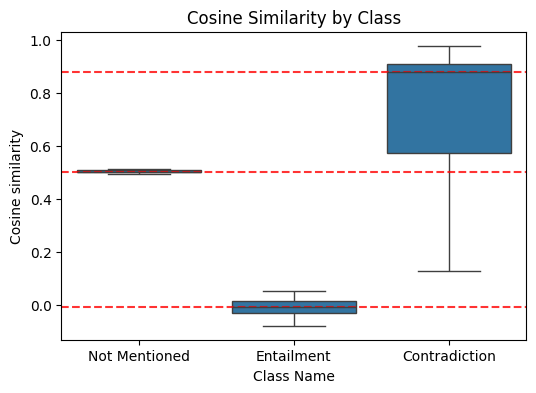

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {0: "Not Mentioned", 1: "Entailment", 2: "Contradiction"}
df['Class Name'] = df['Class'].map(label_map)

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Class Name",
    y="Cosine",
    data=df,
    showfliers=False  # sakriva kružiće/outliere
)

# Dodavanje horizontalne linije za medianu svake klase
medians = df.groupby("Class Name")["Cosine"].median()
for cls, median_val in medians.items():
    plt.axhline(y=median_val, linestyle='--', color='red', alpha=0.8)

plt.title("Cosine Similarity by Class")
plt.ylabel("Cosine similarity")
plt.show()




# Retrieval approach
 Given a new law section, retrieve top k most similar (potentially contradicting) sections

 We use test dataset as a database of sections


In [14]:

#Create embeddings for all premises in the test dataset
print("Creating embeddings for all premises in the dataset...")
all_premises = []
premise_ids = []

for idx, row in df_test_st.iterrows():
    premise = str(row["premise"]) if pd.notna(row["premise"]) and str(row["premise"]).strip() else ""
    if premise:  #nonempty check
        all_premises.append(premise)
        premise_ids.append(idx)

print(f"Created {len(all_premises)} premise embeddings")

# Generate embeddings for all premises
premise_embeddings_db = model_st.encode(
    all_premises,
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=32
)

print(f"Embedding database shape: {premise_embeddings_db.shape}")


Creating embeddings for all premises in the dataset...
Created 1188 premise embeddings


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Embedding database shape: (1188, 768)


Function for retrieving top k most similar (potentially contradicting) premises from the database for a given hypothesis.

In [15]:
def retrieve_contradictions(query_hypothesis, premise_embeddings_db, all_premises, premise_ids, k=10):
    """
    Args:
        query_hypothesis: The hypothesis to search for contradictions
        premise_embeddings_db: Pre-computed embeddings for all premises
        all_premises: List of all premise texts
        premise_ids: List of original indices for premises
        k: Number of top results to return

    Returns:
        List of tuples: (premise_text, similarity_score, original_index)
    """
    #Generate embedding for the query hypothesis
    query_embedding = model_st.encode([query_hypothesis], convert_to_numpy=True)

    #Calculate cosine similarities
    similarities = cosine_similarity(query_embedding, premise_embeddings_db)[0]

    #Get top k indices
    top_k_indices = np.argsort(similarities)[::-1][:k]

    # Return results
    results = []
    for idx in top_k_indices:
        results.append({
            'premise': all_premises[idx],
            'similarity': float(similarities[idx]),
            'original_index': int(premise_ids[idx])
        })

    return results


Test the retrieval algorithm with example queries

In [16]:

test_queries = [
    "Confidential Information shall only include technical information.",
    "All Confidential Information shall be expressly identified by the Disclosing Party."
    "Receiving Party may share some Confidential Information with some third-parties (including consultants, agents and professional advisors)."
]

for i, query in enumerate(test_queries, 1):
    print(f"Query {i}: {query}")
    print("-" * 80)

    results = retrieve_contradictions(
        query,
        premise_embeddings_db,
        all_premises,
        premise_ids,
        k=5
    )

    for j, result in enumerate(results, 1):
        print(f"\nTop {j} (similarity: {result['similarity']:.4f}):")
        print(f"  Premise: {result['premise'][:200]}..." if len(result['premise']) > 200 else f"  Premise: {result['premise']}")



Query 1: Confidential Information shall only include technical information.
--------------------------------------------------------------------------------

Top 1 (similarity: 0.9775):
  Premise: 1. As used herein, "CONFIDENTIAL INFORMATION" shall mean any and all technical and non-technical information provided by either party to the other, including but not limited to (a) patent and patent a...

Top 2 (similarity: 0.9764):
  Premise: Confidential Information includes, but is not limited to, the following types of information and other information of a similar nature (whether or not reduced to writing): trade secrets, inventions, d...

Top 3 (similarity: 0.9764):
  Premise: Confidential Information includes, but is not limited to, the following types of information and other information of a similar nature (whether or not reduced to writing): trade secrets, inventions, d...

Top 4 (similarity: 0.9762):
  Premise: The term "Confidential Information" shall mean for purposes of this Agr